In [77]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Agent imports
from agents.counterfactualregret_mcts import CounterFactualRegretMCTS
from agents.mcts import MonteCarloTreeSearch
from agents.counterfactualregret import CounterFactualRegret
from agents.agent_random import RandomAgent
# Game imports
from games.kuhn3 import KuhnPoker3
from games.kuhn import KuhnPoker
from games.tictactoe import TicTacToe
from importlib import reload
import base.utils
reload(base.utils)
from base.utils import play, run, play_game

def run_simulations(game_class, agent_classes, num_simulations=100,training_iterations=1000):
    results = defaultdict(list)
    for _ in range(num_simulations):
        game = game_class(render_mode='human')
        agents = {agent_name: agent_class(game=game, agent=agent_name) for agent_name, agent_class in zip(game.agents, agent_classes)}
        
        # Train CFR and CFR+MCTS agents before playing
        for agent in agents.values():
            if hasattr(agent, 'train'):
                agent.train(niter=training_iterations)  # Adjust training iterations as needed

        winner, rewards, num_turns = play_game(game, agents)
        results['winners'].append(winner)
        results['rewards'].append(rewards)
        results['num_turns'].append(num_turns)
    return results


In [83]:
from collections import defaultdict

def run_simulations(game_class, agent_combinations, num_simulations=100, training_iterations=100):
    results = defaultdict(list)

    agent_tags = {
        MonteCarloTreeSearch: "MCTS",
        RandomAgent: "Rand",
        CounterFactualRegret: "CFR",
        CounterFactualRegretMCTS: "CFR+MCTS",
    }

    for agent_combo in agent_combinations:
        tag = " & ".join([agent_tags.get(agent_class, "Unknown") for agent_class in agent_combo])

        for _ in range(num_simulations):
            game = game_class(render_mode='human')
            agents = {}
            
            for agent_name, agent_class in zip(game.agents, agent_combo):
                agent = agent_class(game=game, agent=agent_name)
                if hasattr(agent, 'train'): # Entreno si tiene el metodo train (CFR y CFR+MCTS)
                    agent.train(niter=training_iterations) 
                agents[agent_name] = agent

            winner, rewards, num_turns = play_game(game, agents)
            results[tag].append({'winner': winner, 'rewards': rewards, 'num_turns': num_turns})

    return dict(results)


In [85]:
from collections import defaultdict

def run_simulations(game_class, agent_combinations, num_simulations=100, training_iterations=100):
    results = defaultdict(list)

    agent_tags = {
        MonteCarloTreeSearch: "MCTS",
        RandomAgent: "Rand",
        CounterFactualRegret: "CFR",
        CounterFactualRegretMCTS: "CFR+MCTS",
    }

    for agent_combo in agent_combinations:
        tag = " & ".join([agent_tags.get(agent_class, "Unknown") for agent_class in agent_combo])

        # Train agents for this combination
        trained_agents = {}
        for agent_name, agent_class in zip(game_class().agents, agent_combo):
            agent = agent_class(game=game_class(render_mode='human'), agent=agent_name)
            if hasattr(agent, 'train'):
                agent.train(niter=training_iterations)
            trained_agents[agent_name] = agent

        # Run simulations with trained agents
        for _ in range(num_simulations):
            game = game_class(render_mode='human')
            agents = {agent_name: trained_agents[agent_name] for agent_name in game.agents}

            winner, rewards, num_turns = play_game(game, agents)
            results[tag].append({'winner': winner, 'rewards': rewards, 'num_turns': num_turns})

    return dict(results)


In [86]:
# Combinaciones para 2 jugadores
agent_combinations_2p = [
    (MonteCarloTreeSearch, RandomAgent),
    (CounterFactualRegret, MonteCarloTreeSearch),
    # (CounterFactualRegretMCTS, MonteCarloTreeSearch)
]

# Combinaciones para 3 jugadores
agent_combinations_3p = [
    (MonteCarloTreeSearch, RandomAgent, CounterFactualRegret),
    (MonteCarloTreeSearch, RandomAgent, RandomAgent),
    (RandomAgent, RandomAgent, CounterFactualRegret),
]

simulation_data = {}

num_simulations = 1
training_iterations = 3

# Simular juegos de 2 Jugadores 
for game in [KuhnPoker]:
    simulation_data[game.__name__] = run_simulations(game, agent_combinations_2p, num_simulations=num_simulations, training_iterations=training_iterations)

# Simulo juegos de 3 Jugadores
for game in [KuhnPoker3]:
    simulation_data[game.__name__] = run_simulations(game, agent_combinations_3p, num_simulations=num_simulations, training_iterations=training_iterations)


AttributeError: 'KuhnPoker' object has no attribute 'agent_selection'

In [89]:
from collections import defaultdict
import copy

# Combinaciones para 2 jugadores
agent_combinations_2p = [
    (MonteCarloTreeSearch, RandomAgent),
    (CounterFactualRegret, MonteCarloTreeSearch),
    # (CounterFactualRegretMCTS, MonteCarloTreeSearch)
]

# Combinaciones para 3 jugadores
agent_combinations_3p = [
    (MonteCarloTreeSearch, RandomAgent, CounterFactualRegret),
    (MonteCarloTreeSearch, RandomAgent, RandomAgent),
    (RandomAgent, RandomAgent, CounterFactualRegret),
]


def run_simulations(game_class, agent_combinations, trained_agents, num_simulations=100):
    results = defaultdict(list)

    # Run simulations using pre-trained agents
    for agent_combo in agent_combinations:
        agents_for_combo = []
        for agent_class in agent_combo:
            if agent_class in trained_agents:
                # Clone or reset the pre-trained agent
                agent = copy.deepcopy(trained_agents[agent_class])
            else:
                # Create a new agent if it was not pre-trained
                temp_game = game_class(render_mode='human')
                agent = agent_class(game=temp_game, agent=temp_game.agents[0])
            agents_for_combo.append(agent)

        for _ in range(num_simulations):
            game = game_class(render_mode='human')
            agents = {}
            for agent_name, agent in zip(game.agents, agents_for_combo):
                agent.game = game  # Update game reference
                agent.agent = agent_name  # Update agent name
                agents[agent_name] = agent

            winner, rewards, num_turns = play_game(game, agents)
            results[str(agent_combo)].append({'winner': winner, 'rewards': rewards, 'num_turns': num_turns})

    return dict(results)

# Train agents
trained_agents = {}
training_iterations = 1000
agent_classes_to_train = [CounterFactualRegret, CounterFactualRegretMCTS]
for agent_class in agent_classes_to_train:
    temp_game = KuhnPoker(render_mode='human')  # Example game for training
    agent = agent_class(game=temp_game, agent=temp_game.agents[0])
    agent.train(niter=training_iterations)
    trained_agents[agent_class] = agent

# Run simulations with pre-trained agents
simulation_data = {}
num_simulations = 100
for game in [KuhnPoker, KuhnPoker3]:
    agent_combinations = agent_combinations_2p if game in [KuhnPoker,TicTacToe] else agent_combinations_3p
    simulation_data[game.__name__] = run_simulations(game, agent_combinations, trained_agents, num_simulations=num_simulations)


agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 K 
agent_1 Q 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 
agent_1 K 
agent_0 J 

In [88]:
simulation_data

{'KuhnPoker': {"(<class 'agents.mcts.MonteCarloTreeSearch'>, <class 'agents.agent_random.RandomAgent'>)": [{'winner': 'agent_0',
    'rewards': {'agent_0': 1, 'agent_1': -1},
    'num_turns': 1}],
  "(<class 'agents.counterfactualregret.CounterFactualRegret'>, <class 'agents.mcts.MonteCarloTreeSearch'>)": [{'winner': 'agent_0',
    'rewards': {'agent_0': 1, 'agent_1': -1},
    'num_turns': 2}]},
 'KuhnPoker3': {"(<class 'agents.mcts.MonteCarloTreeSearch'>, <class 'agents.agent_random.RandomAgent'>, <class 'agents.counterfactualregret.CounterFactualRegret'>)": [{'winner': 'agent_1',
    'rewards': {'agent_0': -1, 'agent_1': 2, 'agent_2': -1},
    'num_turns': 1}],
  "(<class 'agents.mcts.MonteCarloTreeSearch'>, <class 'agents.agent_random.RandomAgent'>, <class 'agents.agent_random.RandomAgent'>)": [{'winner': 'agent_0',
    'rewards': {'agent_0': 2, 'agent_1': -1, 'agent_2': -1},
    'num_turns': 1}],
  "(<class 'agents.agent_random.RandomAgent'>, <class 'agents.agent_random.RandomAgent

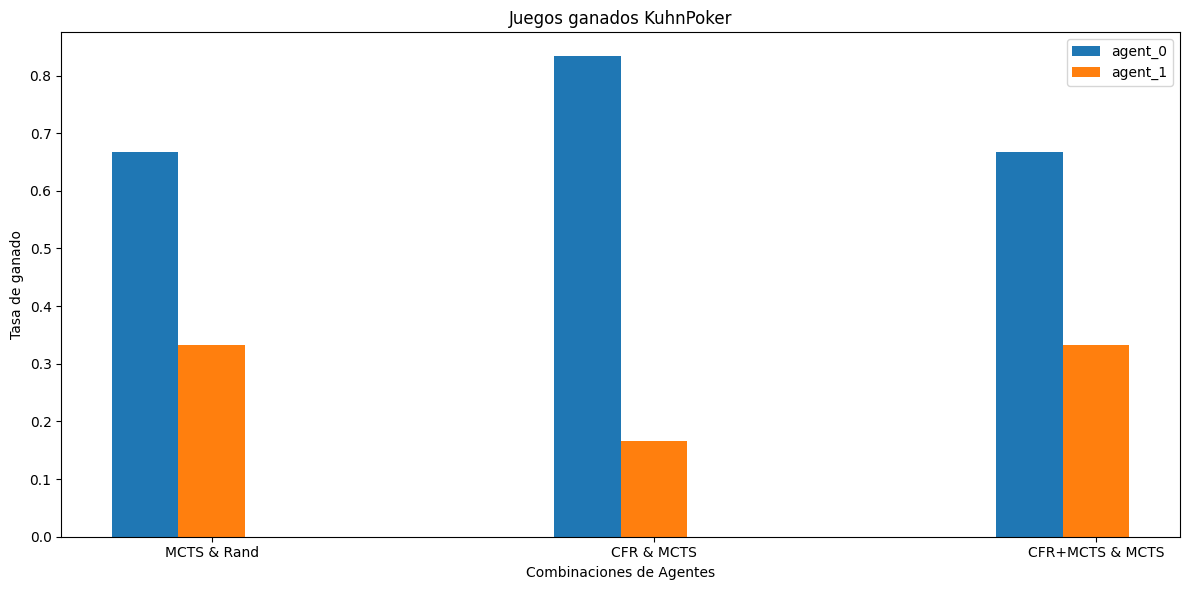

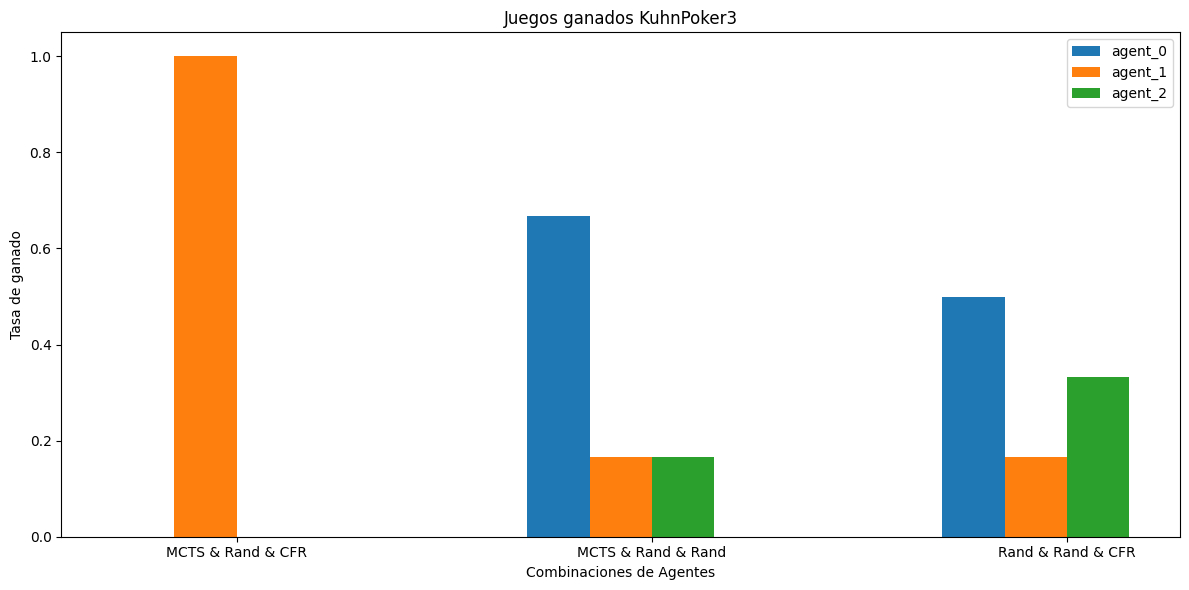

In [66]:
def plot_win_rates(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))

        all_players = set()
        for combo_results in game_results.values():
            for result in combo_results:
                all_players.add(result['winner'])
        all_players = sorted(list(all_players))

        n_groups = len(game_results)
        bar_width = 0.15
        index = np.arange(n_groups)

        for i, player in enumerate(all_players):
            win_rates = []
            for agent_combo, combo_results in game_results.items():
                win_counts = sum(result['winner'] == player for result in combo_results)
                win_rate = win_counts / len(combo_results)
                win_rates.append(win_rate)

            plt.bar(index + i * bar_width, win_rates, bar_width, label=f"{player}")

        plt.title(f'Juegos ganados {game_name}')
        plt.xlabel('Combinaciones de Agentes')
        plt.ylabel('Tasa de ganado')
        plt.xticks(index + bar_width * len(all_players) / 2, game_results.keys(), rotation=0)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_win_rates(simulation_data)

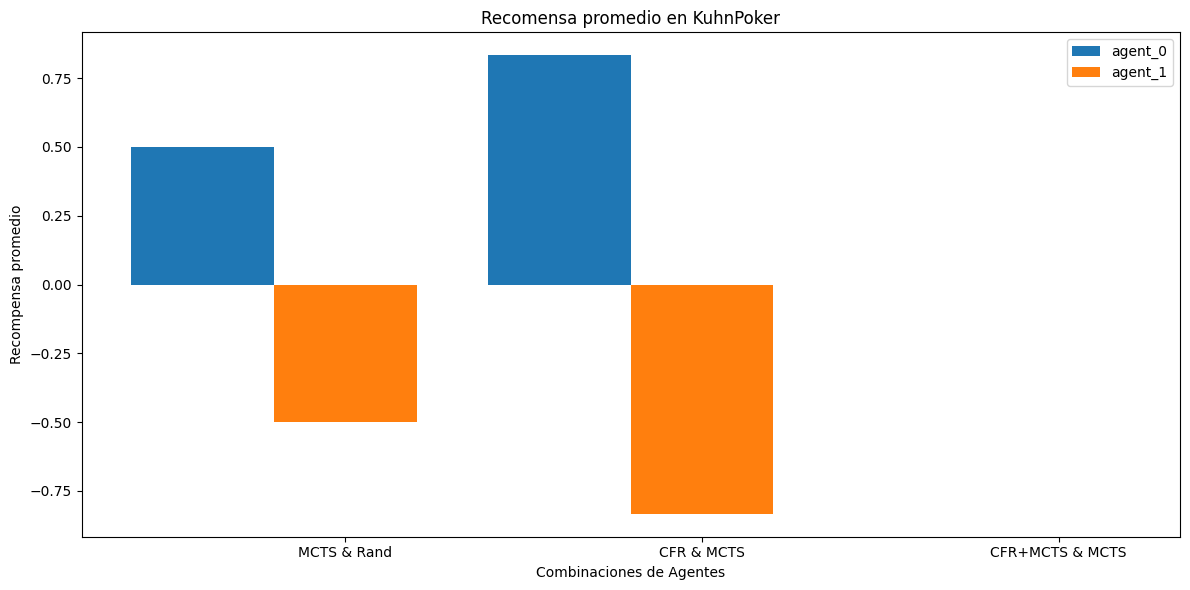

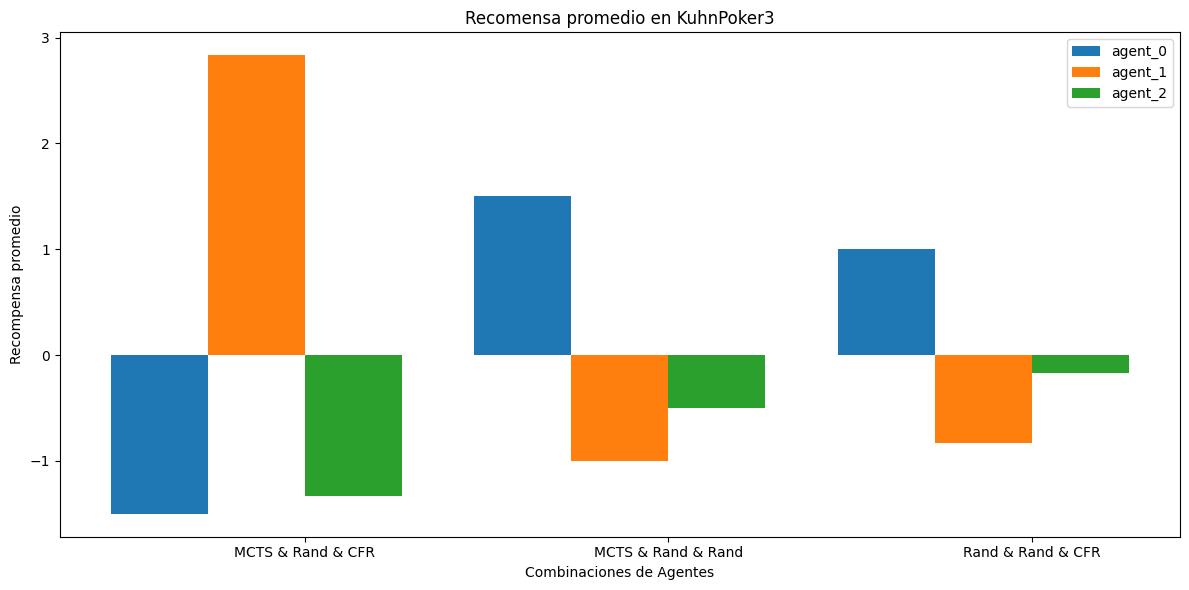

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def plot_average_rewards(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))

        # Initialize data structures for plotting
        combo_labels = []
        agent_rewards = defaultdict(list)
        max_agents = 0

        # Process each agent combination
        for agent_combo, combo_results in game_results.items():
            combo_labels.append(agent_combo)

            # Calculate average rewards for each agent
            for agent_id in combo_results[0]['rewards'].keys():
                avg_reward = np.mean([result['rewards'][agent_id] for result in combo_results])
                agent_rewards[agent_id].append(avg_reward)
            max_agents = max(max_agents, len(combo_results[0]['rewards']))

        # Create a bar plot for each agent
        n_combos = len(combo_labels)
        bar_width = 0.8 / max_agents
        index = np.arange(n_combos)

        for i, (agent_id, rewards) in enumerate(agent_rewards.items()):
            plt.bar(index + i * bar_width, rewards, bar_width, label=f"{agent_id}")

        plt.title(f'Recomensa promedio en {game_name}')
        plt.xlabel('Combinaciones de Agentes')
        plt.ylabel('Recompensa promedio')
        plt.xticks(index + bar_width * max_agents / 2, combo_labels, rotation=0)
        plt.legend()
        plt.tight_layout()
        plt.show()



plot_average_rewards(simulation_data)

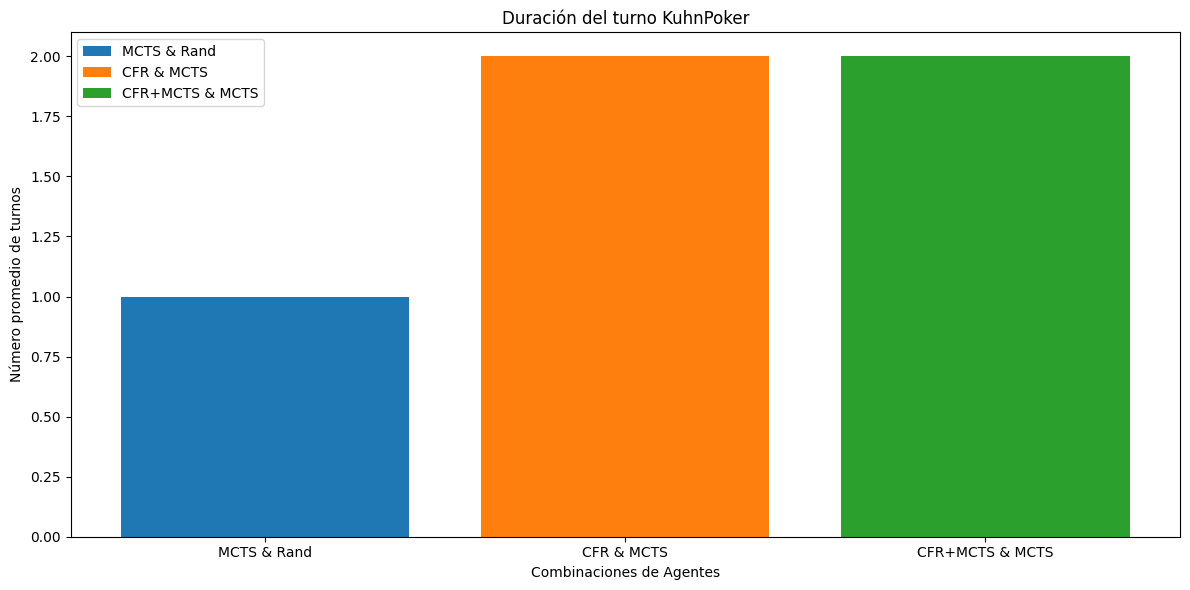

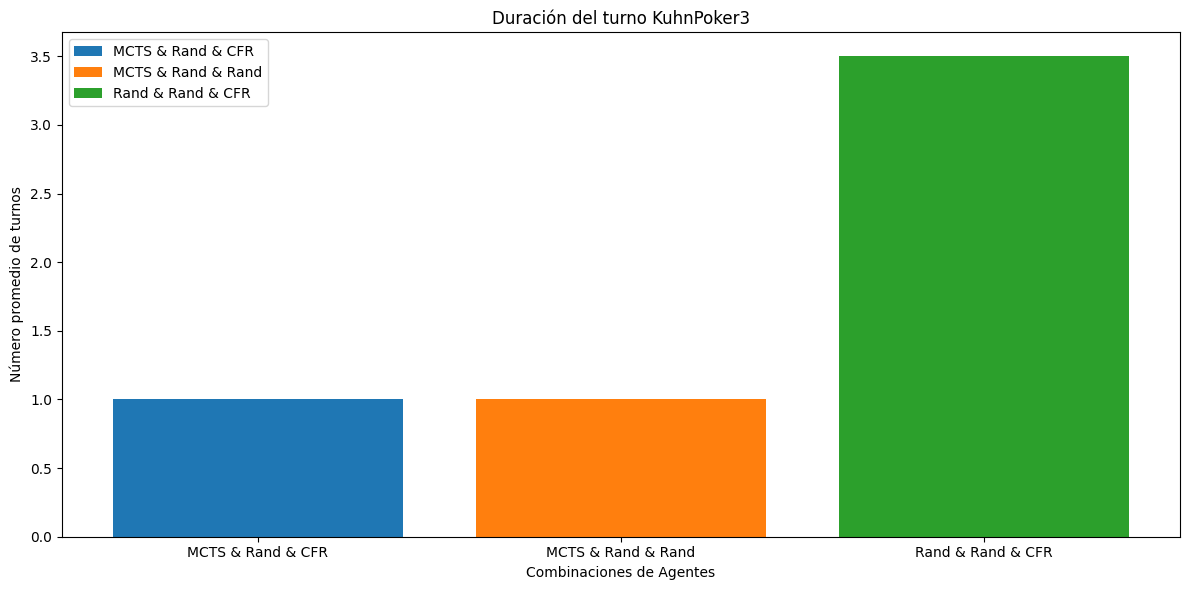

In [68]:
def plot_turn_durations(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))

        for agent_combo, combo_results in game_results.items():
            turn_durations = [result['num_turns'] for result in combo_results]
            plt.bar(agent_combo, np.mean(turn_durations), label=agent_combo)

        plt.title(f'Duración del turno {game_name}')
        plt.xlabel('Combinaciones de Agentes')
        plt.ylabel('Número promedio de turnos')
        plt.xticks(rotation=0)
        plt.legend()
        plt.tight_layout()
        plt.show()
plot_turn_durations(simulation_data)

In [ ]:
# # Define your games and agents
# games = [TicTacToe, KuhnPoker, KuhnPoker3]
# games = [ KuhnPoker, KuhnPoker3]

# agent_combinations = [
#     (MonteCarloTreeSearch, RandomAgent),
#     (CounterFactualRegret, MonteCarloTreeSearch),
#     (CounterFactualRegretMCTS, MonteCarloTreeSearch)
# ]
# # games = [TicTacToe]
# # agent_combinations = [
# #     (MonteCarloTreeSearch, RandomAgent),
# # ]

# # Collect data
# simulation_data = {}
# for game in games:
#     simulation_data[game.__name__] = {}
#     for agents in agent_combinations:
#         print(agent_combinations)
#         sim_results = run_simulations(game, agents, num_simulations=1,training_iterations=1)
#         simulation_data[game.__name__][str(agents)] = sim_results



In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_win_rates(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))

        # Determine the number of unique players across all simulations for spacing the bars
        all_players = set()
        for agent_combo, results in game_results.items():
            all_players.update(results['winners'])
        all_players = sorted(list(all_players))

        # Number of groups (agent combinations)
        n_groups = len(game_results)
        bar_width = 0.15  # Width of the bar
        index = np.arange(n_groups)

        # Create a bar plot for each player
        for i, player in enumerate(all_players):
            win_rates = []
            for agent_combo in game_results:
                win_counts = np.count_nonzero(np.array(game_results[agent_combo]['winners']) == player)
                win_rate = win_counts / len(game_results[agent_combo]['winners'])
                win_rates.append(win_rate)

            plt.bar(index + i * bar_width, win_rates, bar_width, label=f"{player}")

        plt.title(f'Win Rates in {game_name}')
        plt.xlabel('Agent Combinations')
        plt.ylabel('Win Rate')
        plt.xticks(index + bar_width, game_results.keys(), rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_win_rates(simulation_data)


TypeError: list indices must be integers or slices, not str

<Figure size 1200x600 with 0 Axes>

In [ ]:
def plot_average_rewards(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(10, 6))
        for agent_combo, results in game_results.items():
            average_rewards = np.mean(results['rewards'], axis=0)  # Assuming rewards are stored per agent
            plt.bar(agent_combo, average_rewards[0], label=f"{agent_combo} - Player 1")
            plt.bar(agent_combo, average_rewards[1], label=f"{agent_combo} - Player 2", alpha=0.7)

        plt.title(f'Average Rewards in {game_name}')
        plt.ylabel('Average Reward')
        plt.xlabel('Agent Combinations')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

plot_average_rewards(simulation_data)


In [ ]:
# Assuming you have strategy data in the format: {game_name: {agent_combo: [strategy_over_iterations]}}
strategy_data = {}  # Fill this with your strategy tracking data

def plot_strategy_convergence(strategy_data, game_name, agent_combo):
    strategies = strategy_data[game_name][agent_combo]
    iterations = np.arange(len(strategies))
    plt.figure(figsize=(10, 6))

    for action_idx in range(strategies[0].shape[0]):  # Assuming strategies are numpy arrays
        plt.plot(iterations, [strategy[action_idx] for strategy in strategies], label=f'Action {action_idx}')

    plt.title(f'Strategy Convergence in {game_name} - {agent_combo}')
    plt.ylabel('Strategy Probability')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()

# Example: plot_strategy_convergence(strategy_data, 'KuhnPoker', 'CFR')


In [ ]:
def plot_turn_durations(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(10, 6))
        for agent_combo, results in game_results.items():
            avg_turns = np.mean(results['num_turns'])
            plt.bar(agent_combo, avg_turns, label=agent_combo)

        plt.title(f'Average Number of Turns in {game_name}')
        plt.ylabel('Average Turns')
        plt.xlabel('Agent Combinations')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

plot_turn_durations(simulation_data)
